# 数据增广

数据增强
- 增加一个已有的数据集，使得有更多的多样性
    - 在语言里加入各种不同的背景噪音
    - 改变图片的颜色和形状 

总结
- 数据增广通过变形数据来获取多样性从而使模型的泛化性更好
- 常见的图片增广包括反转、切割与变换

In [2]:
%matplotlib inline
import torch, torchvision
from torch import nn
from d2l import torch as d2l

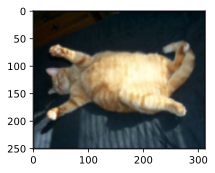

In [3]:
#读取图片
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.png')
d2l.plt.imshow(img)

In [4]:
#定义apply函数，在输入图像img上多次运行图像增广方法并显示结果
def apply(img, aug, num_rows= 2, num_cols= 4, scale= 1.5):
    """展示图像增广的所有结果"""
    Y = [aug(img) for _ in range(num_rows* num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale= scale)

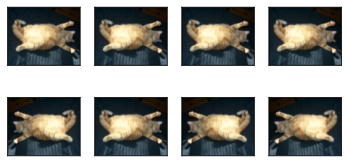

In [5]:
#使用transformer模块实现左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

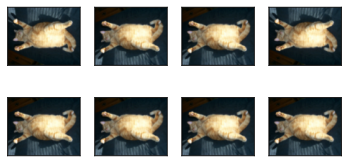

In [6]:
#上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

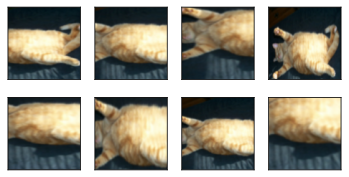

In [7]:
#实现裁剪操作
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale= (0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

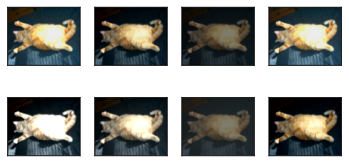

In [8]:
#改变图像的颜色：亮度、对比度、饱和度和色调
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast= 0.5, saturation=0.5, hue= 0))

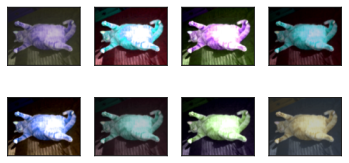

In [9]:
#可以随机更改图像的色调
apply(img, torchvision.transforms.ColorJitter(brightness= 0.5, contrast= 0.5, saturation= 0.5, hue= 0.5))

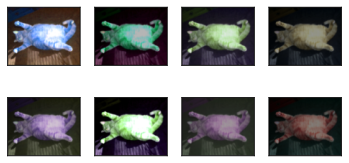

In [10]:
#通过创建ColorJitter实例来随机更改图像颜色
color_aug = torchvision.transforms.ColorJitter(brightness= 0.5, contrast= 0.5, saturation= 0.5, hue= 0.5)
apply(img, color_aug)

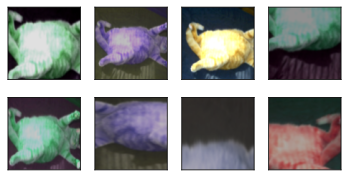

In [11]:
#在实践中，可以结合使用多种图像方法
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

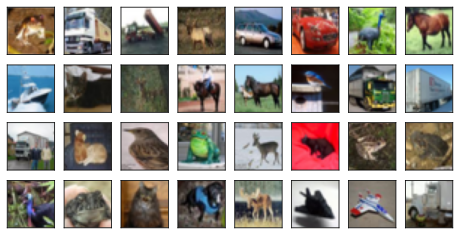

In [12]:
#使用图像增广训练模型
all_images = torchvision.datasets.CIFAR10(train= True, root= '../data', download= True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale= 1) 

In [13]:
#定义一个辅助函数，便于读取图像和应用图像增广
#进行训练时进行图像水平翻转(CIFAR10测试集较稳定，不需要进行复杂的图像增广操作)，进行测试时直接转为tensor形式
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
def load_cifar10(is_train, augs, batch_size):
    """读取数据集并设置数据加载方式"""
    dataset = torchvision.datasets.CIFAR10(root= '../data', train= is_train, 
                                           transform= augs, download= True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, 
                                             shuffle= is_train,  num_workers= d2l.get_dataloader_workers())
    return dataloader

In [29]:
#尝试使用多卡并行推理模型(示例代码：本机仅有一张GPU)
def train_batch_ch13(net, X, y, loss, trainer, devices):  #@save
    """使用多CPU进行小批量训练"""
    if isinstance(X, list):
        #微调BERT所需
        X =  [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    #清空梯度
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    #使用总误差进行反向传播
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()  
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [34]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, 
               devices= d2l.try_all_gpus()):
    """用GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    #动态绘制训练曲线
    animator = d2l.Animator(xlabel= 'epoch', xlim=[1, num_epochs+1],
                            ylim= [0, 1], legend= ['train_loss', 'test_loss', 'test_acc'])
    net = nn.DataParallel(net, device_ids= devices).to(devices[0])
    for epoch in range(num_epochs):
        #4个维度：储存训练损失、训练准确度、实例数、特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, 
                                      labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2] :.3f}, train acc', 
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on', f'{str(devices)}')

In [25]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
#pytorch默认使用Xavier进行模型初始化，这边补充代码说明可以自定义初始化模型参数方法
def init_weights(m):
    '''使用Xavier初始化模型参数'''
    if type(m) in [nn.Linear, nn.Conv2d]:
        #执行原地操作
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr= 0.001):
    '''使用图像增广方式进行模型训练'''
    #构造训练迭代器和测试迭代器
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    #使用交叉熵函数定义损失
    loss = nn.CrossEntropyLoss(reduction= 'none')
    #定义优化器：使用Adam算法优化
    trainer = torch.optim.Adam(net.parameters(), lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.204, train acc 0.929, test acc 0.828
2085.2 examples/sec on [device(type='cuda', index=0)]


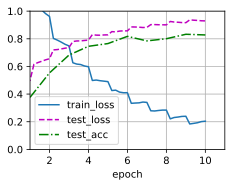

In [35]:
train_with_data_aug(train_augs, test_augs, net)